In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata
import re
import env
import prepare
from wordcloud import WordCloud
from matplotlib import style
style.use("ggplot")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [2]:
#make df from data.json
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [3]:
# how many rows  have readme_contents with length == 0
df[df['readme_contents'].str.len() == 0].language.value_counts()


Jupyter Notebook    10
R                    5
Stata                3
HTML                 2
Python               1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [4]:
df["no_readme_contents"] = df["readme_contents"].str.len()==0
# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
Objective-C         1.000000
Scheme              1.000000
Stata               0.600000
Jupyter Notebook    0.208333
R                   0.161290
HTML                0.090909
Python              0.052632
Dart                0.000000
Java                0.000000
JavaScript          0.000000
MATLAB              0.000000
Ruby                0.000000
Scala               0.000000
Shell               0.000000
Swift               0.000000
TypeScript          0.000000
Name: no_readme_contents, dtype: float64

In [5]:
# how many languages are there?
df['language'].value_counts()

Jupyter Notebook    48
R                   31
HTML                22
Python              19
JavaScript          16
Stata                5
Java                 3
Dart                 3
Scala                2
Swift                2
MATLAB               1
Shell                1
TypeScript           1
Ruby                 1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [6]:
df= prepare.prep_data(df)

In [7]:
df["no_readme_contents"] = df["more_clean"].str.len()==0

# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
HTML      0.0
Other     0.0
Python    0.0
R         0.0
Name: no_readme_contents, dtype: float64

In [8]:
# how many rows do we have
df.shape[0]

134

In [9]:
# how many rows are missing readme data
df[df.no_readme_contents==True].shape[0]

0

In [10]:
df[df.no_readme_contents==True].language.value_counts()

Series([], Name: language, dtype: int64)

In [11]:
df.head()

,repo,language,original,no_readme_contents,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,False,reduction life expectancy brazil covid provide...,seen reduced al based first code publication i...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,False,animated annual change lifeexpectancy illustra...,losseshttpsgithubcomoxforddemsciex lifeexpecta...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,False,thoracic surgery lung cancer data set uci mach...,code first institute tnm one lung registry siz...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,False,hackerrank data scientist hiring test predict ...,first institute prediction united test organiz...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",False,p aligncenter img srchttpsgithubcomoxforddemsc...,functionality code ie sequential issue underta...,2259,234,172,data,relates,code,p,generic


In [12]:
# how many languages are there?
df['language'].value_counts()

Python    56
Other     32
R         26
HTML      20
Name: language, dtype: int64

In [13]:
# make vectorizer
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
y = df['language']

# split data into train and test
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)

In [14]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))


In [15]:
def baseline_accuracy(df, mode):
    """
    Calculate baseline accuracy
    """
    df['mode'] = mode
    baseline_accuracy = accuracy_score(df['actual'], df['mode'])
    return baseline_accuracy

In [16]:
#get mode to use as baseline
mode = df.language.mode().values[0]
#get baseline_accuracy
train_baseline = baseline_accuracy(train, mode)
validate_baseline = baseline_accuracy(validate, mode)
test_baseline = baseline_accuracy(test, mode)



In [17]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False


In [18]:
results.shape[1]

1

In [19]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T
# make more models varying solver
model_number = results.shape[1]
for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
    lm = LogisticRegression(solver=solver).fit(X_train, y_train)
    # run model on data splits
    train['predicted'] = lm.predict(X_train)
    validate['predicted'] = lm.predict(X_validate)
    test['predicted'] = lm.predict(X_test)
    # make results series to add to results df
    stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'include_jupyter_notebook':'Jupyter Notebook' in df.language
        })
    # add to results df
    results = pd.concat([results, stats], axis = 1)
    model_number += 1

results.T.reset_index(drop=True)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,include_jupyter_notebook
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False,NaN
1,1,LogisticRegression,liblinear,0.783784,0.424242,0.444444,False,False
2,2,LogisticRegression,lbfgs,0.851351,0.424242,0.444444,False,False
3,3,LogisticRegression,newton-cg,0.851351,0.424242,0.444444,False,False
4,4,LogisticRegression,sag,0.851351,0.424242,0.444444,False,False
5,5,LogisticRegression,saga,0.891892,0.424242,0.444444,False,False


In [20]:
def drop_low_count_languages(df, threshold=3):
    """
    Drop languages with less than threshold number of entries
    """
    languages = (df['language'].value_counts()>3)
    to_keep = languages[languages==True].index.tolist()
    df = df[df['language'].isin(to_keep)]
    return df

In [21]:
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
X

<134x4418 sparse matrix of type '<class 'numpy.float64'>'
	with 10335 stored elements in Compressed Sparse Row format>

In [22]:
def run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3):
    """
    Run models on data varying solver
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        lm = LogisticRegression(solver=solver).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = lm.predict(X_train)
        validate['predicted'] = lm.predict(X_validate)
        test['predicted'] = lm.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'baseline_accuracy':validate_baseline,
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'drop_jupyter':drop_jupyter,
            'drop_low_count_languages':drop_low_count_langs,
            'n_languages':n_languages
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)


In [23]:
run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.333333,0.347826,0.315789,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.882353,0.347826,0.368421,False,True,True,3
2,2,LogisticRegression,lbfgs,0.901961,0.347826,0.368421,False,True,True,3
3,3,LogisticRegression,newton-cg,0.901961,0.347826,0.368421,False,True,True,3
4,4,LogisticRegression,sag,0.901961,0.347826,0.368421,False,True,True,3
5,5,LogisticRegression,saga,0.901961,0.347826,0.421053,False,True,True,3


In [24]:
run_models(drop_jupyter=False, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.346154,0.323529,0.344828,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.871795,0.382353,0.344828,True,False,True,3
2,2,LogisticRegression,lbfgs,0.923077,0.382353,0.37931,True,False,True,3
3,3,LogisticRegression,newton-cg,0.923077,0.382353,0.37931,True,False,True,3
4,4,LogisticRegression,sag,0.923077,0.382353,0.37931,True,False,True,3
5,5,LogisticRegression,saga,0.923077,0.382353,0.344828,True,False,True,3


In [25]:
run_models(drop_jupyter=False, drop_low_count_langs=False, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.391304,0.4,0.382353,False,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.695652,0.5,0.411765,True,False,False,3
2,2,LogisticRegression,lbfgs,0.782609,0.525,0.441176,True,False,False,3
3,3,LogisticRegression,newton-cg,0.782609,0.525,0.441176,True,False,False,3
4,4,LogisticRegression,sag,0.782609,0.525,0.441176,True,False,False,3
5,5,LogisticRegression,saga,0.793478,0.525,0.441176,True,False,False,3


In [26]:
def run_models2(drop_jupyter=True, drop_low_count_langs=True, drop_empty_readmes=True, n_languages=3):
    """
    Run models on data varying solver and C value
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    if drop_empty_readmes:
        df = df[df['more_clean'] != '']
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'baseline_accuracy':validate_baseline,
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                'drop_jupyter':drop_jupyter,
                'drop_low_count_languages':drop_low_count_langs,
                'drop_empty_readmes':drop_empty_readmes,
                'n_languages':n_languages
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [27]:
run_models2(drop_jupyter=True, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
28,28,LogisticRegression,sag,1.0,0.7,0.352941,True,1000,True,True,True,3
7,7,LogisticRegression,liblinear,1.0,0.7,0.470588,True,1000,True,True,True,3
21,21,LogisticRegression,newton-cg,1.0,0.7,0.411765,True,1000,True,True,True,3


In [28]:
run_models2(drop_jupyter=False, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
33,33,LogisticRegression,saga,1.0,0.551724,0.541667,True,10,False,True,True,3
5,5,LogisticRegression,liblinear,1.0,0.551724,0.583333,True,10,False,True,True,3
26,26,LogisticRegression,sag,1.0,0.551724,0.625,True,10,False,True,True,3


In [29]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
0,baseline,baseline,NaN,0.397436,0.411765,0.392857,False,NaN,NaN,NaN,NaN,NaN
15,15,LogisticRegression,newton-cg,0.397436,0.411765,0.392857,False,0.001,False,False,True,3
32,32,LogisticRegression,saga,0.910256,0.411765,0.571429,False,1,False,False,True,3


In [30]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, drop_empty_readmes=True, n_languages=3).sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
5,5,LogisticRegression,liblinear,1.0,0.411765,0.571429,False,10,False,False,True,3
11,11,LogisticRegression,lbfgs,0.897436,0.411765,0.571429,False,1,False,False,True,3
12,12,LogisticRegression,lbfgs,1.0,0.411765,0.571429,False,10,False,False,True,3


In [31]:
# moved to prepare.py
# 
# # which word is the most common in the string
# def n_most_common_word(string, n=1):
#     """
#     Return the most common word in a string
#     """
#     words = string.split()
#     if len(words) < n:
#         return ''
#     word_counts = Counter(words)
#     return word_counts.most_common(n)[n-1][0]

# n_most_common_word(df.more_clean[1],3)

In [70]:
def run_models5():
    """
    Run models on data varying solver and C value
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'baseline_accuracy':validate_baseline,
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [73]:
run_models5().sort_values(['validate_accuracy', 'test_accuracy'], ascending=False).head(10)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
14,14,LogisticRegression,0.986486,0.606061,0.555556,True,lbfgs,1000,0.424242
21,21,LogisticRegression,0.986486,0.606061,0.555556,True,newton-cg,1000,0.424242
6,6,LogisticRegression,0.986486,0.606061,0.518519,True,liblinear,100,0.424242
7,7,LogisticRegression,0.986486,0.575758,0.555556,True,liblinear,1000,0.424242
13,13,LogisticRegression,0.986486,0.575758,0.555556,True,lbfgs,100,0.424242
20,20,LogisticRegression,0.986486,0.575758,0.555556,True,newton-cg,100,0.424242
27,27,LogisticRegression,0.986486,0.545455,0.592593,True,sag,100,0.424242
28,28,LogisticRegression,0.986486,0.545455,0.592593,True,sag,1000,0.424242
5,5,LogisticRegression,0.986486,0.545455,0.518519,True,liblinear,10,0.424242
12,12,LogisticRegression,0.986486,0.545455,0.518519,True,lbfgs,10,0.424242


In [75]:
def run_models3():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    for max_depth in max_depths:
        #make the model
        dtc = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = dtc.predict(X_train)
        validate['predicted'] = dtc.predict(X_validate)
        test['predicted'] = dtc.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'DecisionTreeClassifier',
            'max_depth':max_depth,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'baseline_accuracy':validate_baseline,
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)

In [74]:
run_models3().sort_values(['validate_accuracy', 'test_accuracy'], ascending=False).head(10)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth
2,2,DecisionTreeClassifier,NaN,0.513514,0.454545,0.333333,True,2
5,5,DecisionTreeClassifier,NaN,0.72973,0.454545,0.333333,True,5
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False,NaN
1,1,DecisionTreeClassifier,NaN,0.418919,0.424242,0.407407,False,1
6,6,DecisionTreeClassifier,NaN,0.959459,0.424242,0.37037,False,10
7,7,DecisionTreeClassifier,NaN,0.986486,0.424242,0.37037,False,100
4,4,DecisionTreeClassifier,NaN,0.662162,0.424242,0.333333,False,4
3,3,DecisionTreeClassifier,NaN,0.581081,0.393939,0.333333,False,3


In [38]:
def run_models4():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    min_sample_leafs = [1, 2, 3, 4, 5, 10, 100]
    criterion = ['gini', 'entropy']
    for max_depth in max_depths:
        for min_samples_leaf in min_sample_leafs:
            for crit in criterion: 
                #make the model
                rf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, criterion=crit).fit(X_train, y_train)
                # run model on data splits
                train['predicted'] = rf.predict(X_train)
                validate['predicted'] = rf.predict(X_validate)
                test['predicted'] = rf.predict(X_test)
                # make results series to add to results df
                stats = pd.Series(
                {'model_number':model_number,
                    'model_type':'RandomForest',
                    'max_depth':max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'criterion':crit,
                    'train_accuracy':accuracy_score(y_train, train['predicted']),
                    'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                    'test_accuracy':accuracy_score(y_test, test['predicted']),
                    'baseline_accuracy':validate_baseline,
                    'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                })
                # add to results df
                results = pd.concat([results, stats], axis = 1)
                model_number += 1

    return results.T.reset_index(drop=True)

In [76]:
results = run_models4()#.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,min_samples_leaf,criterion
0,baseline,baseline,0.418919,0.424242,0.407407,False,NaN,NaN,NaN
1,1,RandomForest,0.432432,0.424242,0.407407,False,1,1,gini
2,2,RandomForest,0.432432,0.424242,0.407407,False,1,1,entropy
3,3,RandomForest,0.432432,0.424242,0.407407,False,1,2,gini
4,4,RandomForest,0.432432,0.424242,0.407407,False,1,2,entropy
...,...,...,...,...,...,...,...,...,...
94,94,RandomForest,0.418919,0.424242,0.407407,False,100,5,entropy
95,95,RandomForest,0.418919,0.424242,0.407407,False,100,10,gini
96,96,RandomForest,0.418919,0.424242,0.407407,False,100,10,entropy
97,97,RandomForest,0.418919,0.424242,0.407407,False,100,100,gini


In [77]:
results.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,min_samples_leaf,criterion
85,85,RandomForest,0.986486,0.484848,0.481481,True,100,1,gini
73,73,RandomForest,0.810811,0.484848,0.444444,True,10,2,gini
74,74,RandomForest,0.783784,0.484848,0.444444,True,10,2,entropy


In [105]:
df = pd.read_json('data.json')
df = prepare.prep_data(df)
train = prepare.split_data(df)[0]
train.head()

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
114,BenceToth/ceu_life-expectancy,HTML,# ceu_life-expectancy\nFinding relationship be...,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,601,57,44,data,across,various,country,life
153,rifkegribenes/d3-scatterplot,Other,## Visualize Data with a Scatterplot Graph (Fr...,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,567,52,41,data,scatterplot,graph,project,see
152,elabuel-o/choropleth-map1,R,## choropleth-map1 Repository\n\n### Purpose\n...,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,384,39,28,data,format,life,expectancy,available
150,MRdNk/DeathAndTaxes,Other,DeathAndTaxes\n=============\n\nDeath and Taxe...,deathandtaxes death tax show life expectancy b...,deathandtaxes death data bristol visualisation...,140,14,14,deathandtaxes,death,tax,show,life
84,FreshOats/LifeExpectancy_v_GDP,Python,# Life Expectancy vs GDP\nCapstone Project usi...,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,210,19,16,life,expectancy,gdp,v,capstone


In [44]:
def get_common_unique_words(text, threshold=5):
    """
    Get common unique words in dataframe, aka words that occur in multiple readme's
    a word must appear in at least threshold readmes to be considered a common word
    """

    words = text.split()
    counter = Counter(words)
    common_unique_words = [word for word, count in counter.items() if count >= threshold]
    new_string = ' '.join(common_unique_words)
    return new_string

In [106]:
# combine all strings in more_clean where language is the same
languages = train.groupby('language')['more_clean'].apply(lambda x: ' '.join(x)).reset_index()
languages.rename(columns={'more_clean':'all_words'}, inplace=True)
languages['unique_words'] = train.groupby('language')['unique_words'].apply(lambda x: ' '.join(x)).values
languages['common_unique_words'] = languages.unique_words.apply(get_common_unique_words)
languages['n_words'] = languages['all_words'].apply(lambda x: len(x.split()))
languages['unique_word_count'] = languages['all_words'].apply(lambda x: len(set(x.split())))
languages['mean_word_count'] = train.groupby('language')['word_count'].mean().values.round(1)
languages['median_word_count'] = train.groupby('language')['word_count'].median().values.round(1)
languages['most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x))
languages['2nd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,2))
languages['3rd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,3))
languages['4th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,4))
languages['5th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,5))
languages


,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,HTML,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,data year life country expectancy project anal...,829,428,63.8,35.0,life,expectancy,data,project,year
1,Other,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,project see data user life expectancy used usi...,2097,836,131.1,37.0,life,expectancy,see,project,data
2,Python,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,python project correlation expectancy using gd...,5040,1776,148.2,92.5,expectancy,life,data,project,using
3,R,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,data life expectancy result r year age model u...,3509,1161,319.0,100.0,life,expectancy,data,r,result


In [126]:
# makes sets of all words in all languages so no words are repeated
html_set = set(languages[languages.language=='HTML'].common_unique_words.values[0].split())
python_set = set(languages[languages.language=='Python'].common_unique_words.values[0].split())
r_set = set(languages[languages.language=='R'].common_unique_words.values[0].split())
other_set = set(languages[languages.language=='Other'].common_unique_words.values[0].split())
#remove words found in other languages
unique_to_html = " ".join(html_set - python_set - r_set - other_set)
unique_to_python = " ".join(python_set - html_set - r_set - other_set)
unique_to_r = " ".join(r_set - html_set - python_set - other_set)
unique_to_other = " ".join(other_set - html_set - python_set - r_set)
# make a series to add to the dataframe
unique_to_lang = [unique_to_html, unique_to_other, unique_to_python, unique_to_r]


# unique to lang is performed on full df but will be done on train then used for model


In [127]:
languages['unique_to_language'] = unique_to_lang
languages.head()

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language
0,HTML,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,data year life country expectancy project anal...,829,428,63.8,35.0,life,expectancy,data,project,year,
1,Other,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,project see data user life expectancy used usi...,2097,836,131.1,37.0,life,expectancy,see,project,data,clone user
2,Python,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,python project correlation expectancy using gd...,5040,1776,148.2,92.5,expectancy,life,data,project,using,based first prediction developing etc one unit...
3,R,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,data life expectancy result r year age model u...,3509,1161,319.0,100.0,life,expectancy,data,r,result,r


In [128]:
languages[['language','unique_to_language']]

,language,unique_to_language
0,HTML,
1,Other,clone user
2,Python,based first prediction developing etc one unit...
3,R,r


In [130]:
len(languages[languages.language == 'Python']['unique_to_language'].values[0].split())


67

In [132]:
languages[languages.language == 'Python']['unique_to_language'].values[0]

'based first prediction developing etc one united alcohol python exploratory linear disease organization gdp various predicting repository machine also status use different example caput set population nation source information per resource human mortality u visualization time health well people income following developed case value birth decision factor total expenditure among index correlation made file world tree global feature fit method dataset death variable predict economic learning rate'

In [118]:
list(languages[languages.language == 'Other']['unique_to_language'].values[0])

['clone', 'user']

In [137]:
languages[languages.language == 'R']['unique_to_language'].values[0]

'r'

(-0.5, 399.5, 199.5, -0.5)

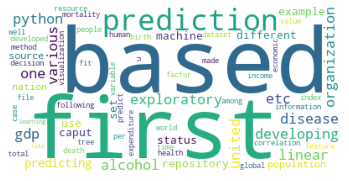

In [133]:
img = WordCloud(background_color='white').generate(languages[languages.language == 'Python']['unique_to_language'].values[0])
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

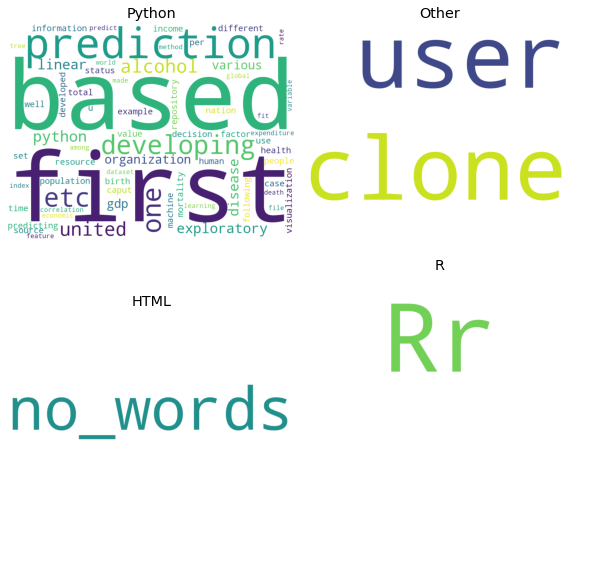

In [165]:
r_cloud = WordCloud(background_color='white', height=1000, width=400).generate("Rr  ")
html_cloud = WordCloud(background_color='white', height=600, width=800).generate("no_words")
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(languages[languages.language == 'Python']['unique_to_language'].values[0])
other_cloud = WordCloud(background_color='white', height=600, width=800).generate(languages[languages.language == 'Other']['unique_to_language'].values[0])

plt.figure(figsize=(8, 8))
axs = [plt.axes([0, .5, .5, .5]), plt.axes([0, 0, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([.5, .5, .5, .5])]

axs[0].imshow(python_cloud)
axs[1].imshow(html_cloud)
axs[2].imshow(r_cloud)
axs[3].imshow(other_cloud)

axs[0].set_title('Python')
axs[1].set_title('HTML')
axs[2].set_title('R')
axs[3].set_title('Other')

for ax in axs: ax.axis('off')


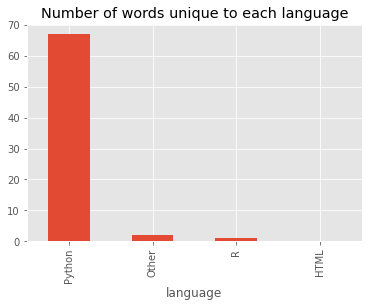

In [206]:
# graph number of words in unique_to_language
new_df= languages[['language','unique_to_language']]
#new_df.set_index('language', inplace=True)
new_df['unique_words'] = new_df['unique_to_language'].apply(lambda x: len(x.split()))
new_df.sort_values(by='unique_words', ascending=False, inplace=True)
new_df.plot.bar(x='language', y='unique_words')
plt.title('Number of words unique to each language')
plt.legend().set_visible(False)


In [208]:
other = (' '.join(train[train.language == 'Other'].more_clean)).split()
python = (' '.join(train[train.language == 'Python'].more_clean)).split()
r = (' '.join(train[train.language == 'R'].more_clean)).split()
html = (' '.join(train[train.language == 'HTML'].more_clean)).split()
all_words = (' '.join(train.more_clean)).split()

In [213]:
# make bigrams
top_5_other_bigrams = (pd.Series(nltk.ngrams(other, 2)).value_counts().head(5))
top_5_python_bigrams = (pd.Series(nltk.ngrams(python, 2)).value_counts().head(5))
top_5_r_bigrams = (pd.Series(nltk.ngrams(r, 2)).value_counts().head(5))
top_5_html_bigrams = (pd.Series(nltk.ngrams(html, 2)).value_counts().head(5))


(life, expectancy)    41
(sex, age)            15
(file, life)          14
(expectancy, sex)     14
(age, income)         12
dtype: int64

Text(0.5, 1.0, 'R')

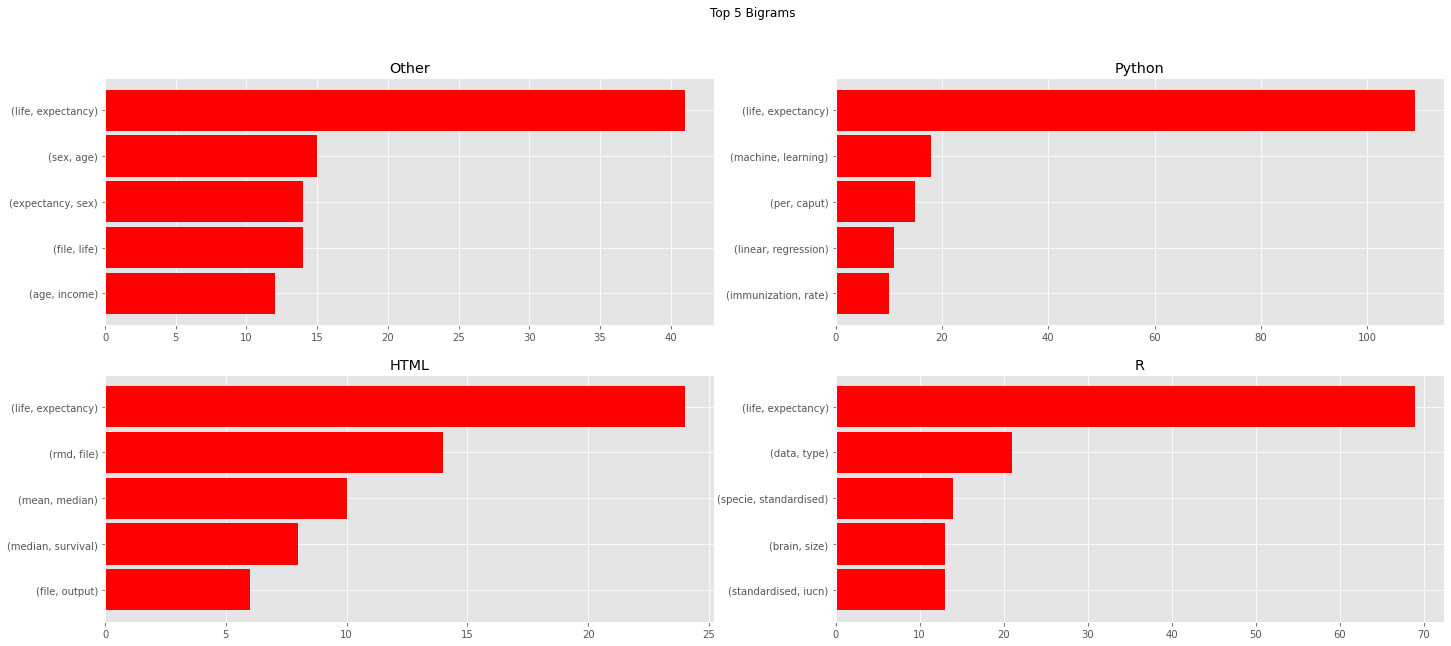

In [263]:
## Plot Top 5 Bigrams
fig, axs = plt.subplots(2, 2)
#set figure size
fig.set_size_inches(24, 10)
#set title
plt.suptitle('Top 5 Bigrams')
top_5_other_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[0, 0])
axs[0,0].set_title('Other')
#axs[0,0].set_ylabel('Bigram')

top_5_python_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[0, 1])
axs[0,1].set_title('Python')

top_5_html_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[1, 0])
axs[1,0].set_title('HTML')

top_5_r_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[1, 1])
axs[1,1].set_title('R')


In [266]:
languages.head()

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language
0,HTML,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,data year life country expectancy project anal...,829,428,63.8,35.0,life,expectancy,data,project,year,
1,Other,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,project see data user life expectancy used usi...,2097,836,131.1,37.0,life,expectancy,see,project,data,clone user
2,Python,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,python project correlation expectancy using gd...,5040,1776,148.2,92.5,expectancy,life,data,project,using,based first prediction developing etc one unit...
3,R,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,data life expectancy result r year age model u...,3509,1161,319.0,100.0,life,expectancy,data,r,result,r


In [282]:
# add bigrams to language dataframe
languages['bigrams'] = languages.all_words.apply(lambda x: pd.Series(nltk.ngrams(x.split(), 2)).values)

In [305]:
def get_common_bigrams(text, threshold=5):
    '''
    This function takes in a text and returns a list of the top 5 bigrams that are common to the text.
    '''
    # get all bigrams in text
    bigrams = pd.Series(nltk.ngrams(text.split(), 2)).value_counts()
    # filter out bigrams that are less than threshold
    bigrams = bigrams[bigrams > threshold]
    # return all that occur more than 5 times
    return bigrams.index 

In [307]:
languages['common_bigrams'] = languages.all_words.apply(lambda x: get_common_bigrams(x))

In [308]:
languages.head()

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language,bigrams,common_bigrams
0,HTML,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,data year life country expectancy project anal...,829,428,63.8,35.0,life,expectancy,data,project,year,,"[(ceulifeexpectancy, finding), (finding, relat...","Index([('life', 'expectancy'), ('rmd', ..."
1,Other,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,project see data user life expectancy used usi...,2097,836,131.1,37.0,life,expectancy,see,project,data,clone user,"[(visualize, data), (data, scatterplot), (scat...","Index([ ('life', 'expectancy'), ..."
2,Python,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,python project correlation expectancy using gd...,5040,1776,148.2,92.5,expectancy,life,data,project,using,based first prediction developing etc one unit...,"[(life, expectancy), (expectancy, v), (v, gdp)...","Index([ ('life', 'expectancy'), ('..."
3,R,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,data life expectancy result r year age model u...,3509,1161,319.0,100.0,life,expectancy,data,r,result,r,"[(choroplethmap, repository), (repository, pur...","Index([ ('life', 'expectancy'), ..."


In [304]:
get_common_bigrams(languages[languages.language == 'Python']['all_words'].values[0])

Index([       ('life', 'expectancy'),       ('machine', 'learning'),
                    ('per', 'caput'),      ('linear', 'regression'),
            ('immunization', 'rate'),              ('img', 'width'),
                 ('predict', 'life'),         ('among', 'yearolds'),
                      ('gdp', 'per'),     ('expectancy', 'country'),
                ('data', 'analysis'),     ('developing', 'country'),
                    ('bash', 'venv'),  ('immunization', 'coverage'),
                 ('world', 'health'),      ('gradient', 'boosting'),
               ('per', 'population'),         ('coverage', 'among'),
       ('government', 'expenditure'),         ('thinness', 'among'),
           ('expectancy', 'feature'),           ('whether', 'area'),
            ('developed', 'country'),         ('learning', 'model'),
                    ('death', 'per'),        ('predicting', 'life'),
          ('health', 'organization'),   ('developed', 'developing')],
      dtype='object')

In [296]:
pd.Series(nltk.ngrams(languages.all_words[0].split(), 2)).value_counts()

(life, expectancy)                          24
(rmd, file)                                 14
(mean, median)                              10
(median, survival)                           8
(file, output)                               6
                                            ..
(figureboxplotsoffourscenariosrmd, html)     1
(file, four)                                 1
(four, boxplots)                             1
(boxplots, showing)                          1
(published, httprpubscomimorzan)             1
Length: 683, dtype: int64

In [283]:
languages

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language,bigrams
0,HTML,ceulifeexpectancy finding relationship life ex...,article consumption older done geographicalsoc...,data year life country expectancy project anal...,829,428,63.8,35.0,life,expectancy,data,project,year,,"[(ceulifeexpectancy, finding), (finding, relat..."
1,Other,visualize data scatterplot graph freecodecamp ...,cia boring project birth one screenshot factbo...,project see data user life expectancy used usi...,2097,836,131.1,37.0,life,expectancy,see,project,data,clone user,"[(visualize, data), (data, scatterplot), (scat..."
2,Python,life expectancy v gdp capstone project using p...,python project correlation expectancy capstone...,python project correlation expectancy using gd...,5040,1776,148.2,92.5,expectancy,life,data,project,using,based first prediction developing etc one unit...,"[(life, expectancy), (expectancy, v), (v, gdp)..."
3,R,choroplethmap repository purpose create chorop...,sex provided maphttpenwikipediaorgwikichorople...,data life expectancy result r year age model u...,3509,1161,319.0,100.0,life,expectancy,data,r,result,r,"[(choroplethmap, repository), (repository, pur..."


In [287]:
# makes sets of all bigrams in all languages so no bigrams are repeated
html_set = set(languages[languages.language=='HTML'].bigrams.values[0])
python_set = set(languages[languages.language=='Python'].bigrams.values[0])
r_set = set(languages[languages.language=='R'].bigrams.values[0])
other_set = set(languages[languages.language=='Other'].bigrams.values[0])
#remove words found in other languages
unique_to_html = (html_set - python_set - r_set - other_set)
unique_to_python = (python_set - html_set - r_set - other_set)
unique_to_r = (r_set - html_set - python_set - other_set)
unique_to_other = (other_set - html_set - python_set - r_set)
# make a series to add to the dataframe
unique_to_lang = [unique_to_html, unique_to_other, unique_to_python, unique_to_r]

In [288]:
unique_to_lang

[{('abstract', 'project'),
  ('accurate', 'ass'),
  ('across', 'simulation'),
  ('across', 'various'),
  ('activity', 'create'),
  ('activity', 'economic'),
  ('actual', 'data'),
  ('added', 'complexity'),
  ('africa', 'america'),
  ('african', 'nation'),
  ('age', 'older'),
  ('aim', 'project'),
  ('ajmera', 'project'),
  ('alcohol', 'serving'),
  ('also', 'plotted'),
  ('america', 'asia'),
  ('analysis', 'energy'),
  ('analysis', 'including'),
  ('analysis', 'looked'),
  ('analysis', 'nikita'),
  ('analysis', 'philipp'),
  ('analysis', 'seaborn'),
  ('analysis', 'using'),
  ('analytics', 'lab'),
  ('analyze', 'correlation'),
  ('andhtml', 'rmd'),
  ('animation', 'published'),
  ('appears', 'obvious'),
  ('applied', 'morquio'),
  ('approach', 'applied'),
  ('approach', 'attribution'),
  ('around', 'country'),
  ('around', 'globe'),
  ('article', 'found'),
  ('arun', 'janakiraman'),
  ('as', 'knnregression'),
  ('asia', 'use'),
  ('ass', 'life'),
  ('assessing', 'life'),
  ('associated